In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import argparse
from scipy.signal import argrelmax, argrelmin, firwin, convolve
#import scipy as sc
import csv
import glob
import os
from scipy.signal import wiener, filtfilt, butter, gaussian, freqz,medfilt
from scipy.ndimage import filters

In [ ]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [ ]:
root_dir = "/content/drive/MyDrive/Pradeep_redpine/Saket_hospital_PPG_data(1)/Saket_hospital_PPG_data/"
data = 'AB_09.txt'
ppg_raw_data= pd.read_csv(root_dir+data,sep="\t",skiprows=3)
signal=ppg_raw_data.iloc[:,2][0:108000]
signal=np.array(signal)

In [ ]:
#capturing the 3 minutes of data with sampling frequency of 600
PPG_SAMPLE_RATE=600
MINIMUM_PULSE_CYCLE = .50
MAXIMUM_PULSE_CYCLE = 1.5
PPG_FIR_FILTER_TAP_NUM = 600# erlier it was 200 for hypertension model
PPG_FILTER_CUTOFF = [0.5,12 ]
PPG_SYSTOLIC_PEAK_DETECTION_THRESHOLD_COEFFICIENT = .45
t=np.linspace(0 ,len(signal)/PPG_SAMPLE_RATE,len(signal))
len(t)/600


180.0

In [ ]:
norm = signal - np.mean(signal)
norm_sig = []
min_ = norm.min()
#print(min)
max_ = norm.max()
for val in norm:
    norm_sig.append((val-min_)/(max_-min_))

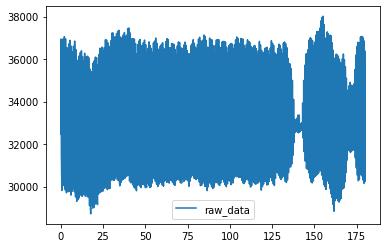

In [ ]:
plt.figure(1)
plt.plot(t,signal,label='raw_data')
plt.legend()
plt.show()

In [ ]:
def find_extrema(signal):
    signal = np.array(signal)
    extrema_index = np.sort(np.unique(np.concatenate((argrelmax(signal)[0], argrelmin(signal)[0]))))
    extrema = signal[extrema_index]
    return zip(extrema_index.tolist(), extrema.tolist()) 

In [ ]:
# Maxima and minima collectively known as extrema.Calculate the relative extrema of data.
# argrelmax - Calculate the relative maxima of data.
# argrelmin - Calculate the relative minima of data.

def smooth_ppg_signal(signal, sample_rate=PPG_SAMPLE_RATE,window='hanning', numtaps=PPG_FIR_FILTER_TAP_NUM, cutoff=PPG_FILTER_CUTOFF):
    if numtaps % 2 == 0:
        numtaps += 1
        print(numtaps)
    return convolve(signal, firwin(numtaps, [x*2/sample_rate for x in cutoff], pass_zero=False), mode='valid')#.tolist()

In [ ]:
#FIR filter design.
#This function computes the coefficients of a finite impulse response filter. The filter will have linear phase; it will be Type I if numtaps is odd and Type II if numtaps is even.
#Type II filters always have zero response at the Nyquist rate, so a ValueError exception is raised if firwin is called with numtaps even and having a passband whose right end is at the Nyquist rate.

#numtaps :Length of the filter (number of coefficients, i.e. the filter order + 1). numtaps must be even if a passband includes the Nyquist frequency.
#pass_zero : bool,If True, the gain at the frequency 0 i.e. the “DC gain” is 1. Otherwise the DC gain is 0 and frequency 1.

#The convolution is determined directly from sums.
#print('Sayan')
def validate_ppg_single_waveform(single_waveform, sample_rate=PPG_SAMPLE_RATE):
    #print(single_waveform)
    period = float(len(single_waveform)) / float(sample_rate)
    #print('@@@@@@@@')
    #print(period) 
    if period < MINIMUM_PULSE_CYCLE or period > MAXIMUM_PULSE_CYCLE:
        return False
    #print('#######')
   # max_index = np.argmax(single_waveform)
    #print("@@@@@@@@@@@@@@",max_index)
    #print(float(max_index) / float(len(single_waveform)))
    #if float(max_index) / float(len(single_waveform)) >= .5:
     #   return False
    #print(len(argrelmax(np.array(single_waveform))[0]))
    #if len(argrelmax(np.array(single_waveform))[0]) < .1:
    #    return False
   # min_index = np.argmin(single_waveform)
    #print(min_index)
    #print(len(single_waveform))
    #if not (min_index == 0 or min_index == len(single_waveform) - 1):
     #   return False
    #diff = np.diff(single_waveform[:max_index+1], n=1)
    #print(min(diff))
    #if min(diff) < 0:
    #    return False
    #print( abs(single_waveform[0] - single_waveform[-1]) / (single_waveform[max_index] - single_waveform[min_index]))
    #if abs(single_waveform[0] - single_waveform[-1]) / (single_waveform[max_index] - single_waveform[min_index]) > 0.1:
     #   return False
    return True


In [ ]:
def extract_ppg_single_waveform(signal, sample_rate=PPG_SAMPLE_RATE):
    #print(signal)
    t=np.linspace(0 ,len(signal)/PPG_SAMPLE_RATE,len(signal))
    
    plt.figure(2)
    plt.plot(t,signal,label='filtered_data')
    plt.legend()
    plt.show()
    
#        with open('filterdata.csv', 'w') as writeFile:
#             writer = csv.writer(writeFile)
#             writer.writerows(map (lambda x:[x],signal))
#        writeFile.close()
    #print(max(signal),min(signal))
    threshold = (max(signal) - min(signal)) * PPG_SYSTOLIC_PEAK_DETECTION_THRESHOLD_COEFFICIENT
    #print(threshold)
    single_waveforms = []
    last_extremum_index = None
    last_extremum = None
    last_single_waveform_start_index = None
    for extremum_index, extremum in find_extrema(signal=signal):
        if last_extremum is not None and extremum - last_extremum > threshold:
            #print(extremum - last_extremum)
            if last_single_waveform_start_index is not None:
                single_waveform = signal[last_single_waveform_start_index:last_extremum_index]
                #print(validate_ppg_single_waveform(single_waveform=single_waveform, sample_rate=sample_rate))
                if validate_ppg_single_waveform(single_waveform=single_waveform, sample_rate=sample_rate):
                       single_waveforms.append(single_waveform)
            last_single_waveform_start_index = last_extremum_index
        last_extremum_index = extremum_index
        last_extremum = extremum
    return single_waveforms 

601


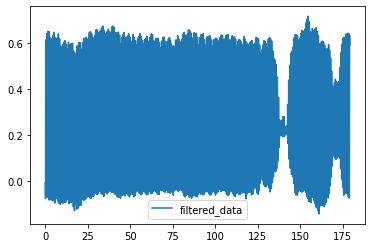

In [ ]:
signal_wav = extract_ppg_single_waveform(signal=smooth_ppg_signal(norm_sig,sample_rate=PPG_SAMPLE_RATE))
 #   s = sc.stats.skew(signal_wav)
   # print(signal_wav)
   # with open('signaldata.csv', 'w') as writeFile:
#         writer = csv.writer(writeFile)
#         writer.writerows(map (lambda x:[x],signal_wav))
#writeFile.close()
#plt.figure(2)
#plt.plot(signal_wav[0],'b')
#plt.show()
# -*- coding: utf-8 -*-
#plt.figure(2)
#plt.plot(signal_wav[0],'b')
#plt.show()


In [ ]:
def extract_ppg45(single_waveform, sample_rate=PPG_SAMPLE_RATE):
    #print("doctor@@@@@@@")
    #plt.figure()
    #plt.plot(single_waveform,'c')
    #plt.show() 
    def __next_pow2(x):
        return 1<<(x-1).bit_length()
    features = []
    maxima_index = argrelmax(np.array(single_waveform))[0]
    #print(maxima_index)
    minima_index = argrelmin(np.array(single_waveform))[0]
    #print(len(maxima_index),len(minima_index))
    derivative_1 = np.diff(single_waveform, n=1) * float(sample_rate)
    derivative_1_maxima_index = argrelmax(np.array(derivative_1))[0]
    derivative_1_minima_index = argrelmin(np.array(derivative_1))[0]
    derivative_2 = np.diff(single_waveform, n=2) * float(sample_rate)
    derivative_2_maxima_index = argrelmax(np.array(derivative_2))[0]
    derivative_2_minima_index = argrelmin(np.array(derivative_2))[0]
    sp_mag = np.abs(np.fft.fft(single_waveform, n=__next_pow2(len(single_waveform))*16))
    #print(sp_mag)
    #print("-----------------------")
    #print(len(single_waveform))
    #print(__next_pow2(len(single_waveform))*16)
    #print("-----------------------")
    freqs = np.fft.fftfreq(len(sp_mag))
    sp_mag_maxima_index = argrelmax(sp_mag)[0]
    #print(sp_mag_maxima_index)
    
    # x
    x = single_waveform[maxima_index[0]]
    features.append(x)
    #print("sssssssssssssssssssssss",x)
    # y
    if(len(maxima_index)) < 2 or len(maxima_index) <1 :
        return
    y = single_waveform[maxima_index[1]]

    features.append(y)
    # z
    z = single_waveform[minima_index[0]]
    features.append(z)
    # t_pi
    t_pi = float(len(single_waveform)) / float(sample_rate)
    features.append(t_pi)
    # y/x
    features.append(y / x)
    # (x-y)/x
    features.append((x - y) / x)
    # z/x
    features.append(z / x)
    # (y-z)/x
    features.append((y - z) / x)
    # t_1
    t_1 = float(maxima_index[0] + 1) / float(sample_rate)
    features.append(t_1)
    # t_2
    t_2 = float(minima_index[0] + 1) / float(sample_rate)
    features.append(t_2)
    # t_3
    t_3 = float(maxima_index[1] + 1) / float(sample_rate)
    features.append(t_3)
    # delta_t
    delta_t = t_3 - t_2
    features.append(delta_t)
    # width
    single_waveform_halfmax = max(single_waveform) / 2
    width = 0
    for value in single_waveform[maxima_index[0]::-1]:
        if value >= single_waveform_halfmax:
            width += 1
        else:
            break
    for value in single_waveform[maxima_index[0]+1:]:
        if value >= single_waveform_halfmax:
            width += 1
        else:
            break
    features.append(float(width) / float(sample_rate))
    # A_2/A_1
    features.append(sum(single_waveform[:maxima_index[0]]) / sum(single_waveform[maxima_index[0]:]))
    # t_1/x
    features.append(t_1 / x)
    # y/(t_pi-t_3)
    features.append(y / (t_pi - t_3))
    # t_1/t_pi
    features.append(t_1 / t_pi)
    # t_2/t_pi
    features.append(t_2 / t_pi)
    # t_3/t_pi
    features.append(t_3 / t_pi)
    # delta_t/t_pi
    features.append(delta_t / t_pi)
    # t_a1
    t_a1 = float(derivative_1_maxima_index[0]) / float(sample_rate)
    features.append(t_a1)
    # t_b1
    t_b1 = float(derivative_1_minima_index[0]) / float(sample_rate)
    features.append(t_b1)
    # t_e1
    t_e1 = float(derivative_1_maxima_index[1]) / float(sample_rate)
    features.append(t_e1)
    # t_f1
    t_f1 = float(derivative_1_minima_index[1]) / float(sample_rate)
    features.append(t_f1)
    # b_2/a_2
    a_2 = derivative_2[derivative_2_maxima_index[0]]
    b_2 = derivative_2[derivative_2_minima_index[0]]
    features.append(b_2 / a_2)
    # e_2/a_2
    if len(derivative_2_maxima_index) < 2 & len(derivative_2_maxima_index) < 1:
        return
    e_2 = derivative_2[derivative_2_maxima_index[1]]
    features.append(e_2 / a_2)
    # (b_2+e_2)/a_2
    features.append((b_2 + e_2) / a_2)
    # t_a2
    t_a2 = float(derivative_2_maxima_index[0]) / float(sample_rate)
    features.append(t_a2)
    # t_b2
    t_b2 = float(derivative_2_minima_index[0]) / float(sample_rate)
    features.append(t_b2)
    # t_a1/t_pi
    features.append(t_a1 / t_pi)
    # t_b1/t_pi
    features.append(t_b1 / t_pi)
    # t_e1/t_pi
    features.append(t_e1 / t_pi)
    # t_f1/t_pi
    features.append(t_f1 / t_pi)
    # t_a2/t_pi
    features.append(t_a2 / t_pi)
    # t_b2/t_pi
    features.append(t_b2 / t_pi)
    # (t_a1-t_a2)/t_pi
    features.append((t_a1 - t_a2) / t_pi)
    # (t_b1-t_b2)/t_pi
    features.append((t_b1 - t_b2) / t_pi)
    # (t_e1-t_2)/t_pi
    features.append((t_e1 - t_2) / t_pi)
    # (t_f1-t_3)/t_pi
    features.append((t_f1 - t_3) / t_pi)
    # f_base 
    f_base = freqs[sp_mag_maxima_index[0]] * sample_rate
    features.append(f_base)
    # sp_mag_base
    sp_mag_base = sp_mag[sp_mag_maxima_index[0]] / len(single_waveform)
    features.append(sp_mag_base)
    # f_2
    f_2 = freqs[sp_mag_maxima_index[1]] * sample_rate
    features.append(f_2)
    # sp_mag_2
    sp_mag_2 = sp_mag[sp_mag_maxima_index[1]] / len(single_waveform)
    features.append(sp_mag_2)
    # f_3   



    f_3 = freqs[sp_mag_maxima_index[2]] * sample_rate
    features.append(f_3)
    # sp_mag_3
    sp_mag_3 = sp_mag[sp_mag_maxima_index[2]] / len(single_waveform)
    features.append(sp_mag_3)
    return features



In [ ]:
signal_feat = pd.DataFrame()
signal_feat['ppg45', 'pradeep'] = [extract_ppg45(single_waveform=single_waveform,sample_rate=PPG_SAMPLE_RATE) for single_waveform in signal_wav]
signal_feat = signal_feat.dropna()
#print(signal_wav)
#print(signal_feat.size)

header_column=[]
if(signal_feat.size > 0):
    signal_feat.to_csv("/content/drive/MyDrive/Pradeep_redpine/Saket_hospital_PPG_data(1)/Feature_BG/Feature_BG_09.csv",header = False, sep='\t', mode = 'a', index=False)
#




IndexError: ignored